In [1]:
import glob
import numpy as np
from matplotlib import pyplot as plt
import pickle

# Loading of patients input files

In [2]:
import plastic

In [3]:
patients = list()
patients_names = list()
for f in glob.glob('medullo/patients/*.txt'):
    patients_names.append(f.split('/')[-1].replace('.txt', ''))
    p = plastic.GenotypeMatrix.from_files(f, cells_file=f'{f}.cells', mutations_file=f'{f}.muts')
    patients.append(p)

# Clustering of mutations for each patient

In [4]:
clustered_patients = list()
for ix, p in enumerate(patients):
    try:
        c = plastic.GenotypeMatrix.from_serializable_dict(
            pickle.load(open(f'medullo/clustered/{patients_names[ix]}.p', 'rb'))
        )
    except:
        c = plastic.clustering.cluster_mutations(p, k=50, n_inits=5, max_iter=50, verbose=True)
        pickle.dump(c.to_serializable_dict(), open(f'medullo/clustered/{patients_names[ix]}.p', 'wb'))
    clustered_patients.append(c)

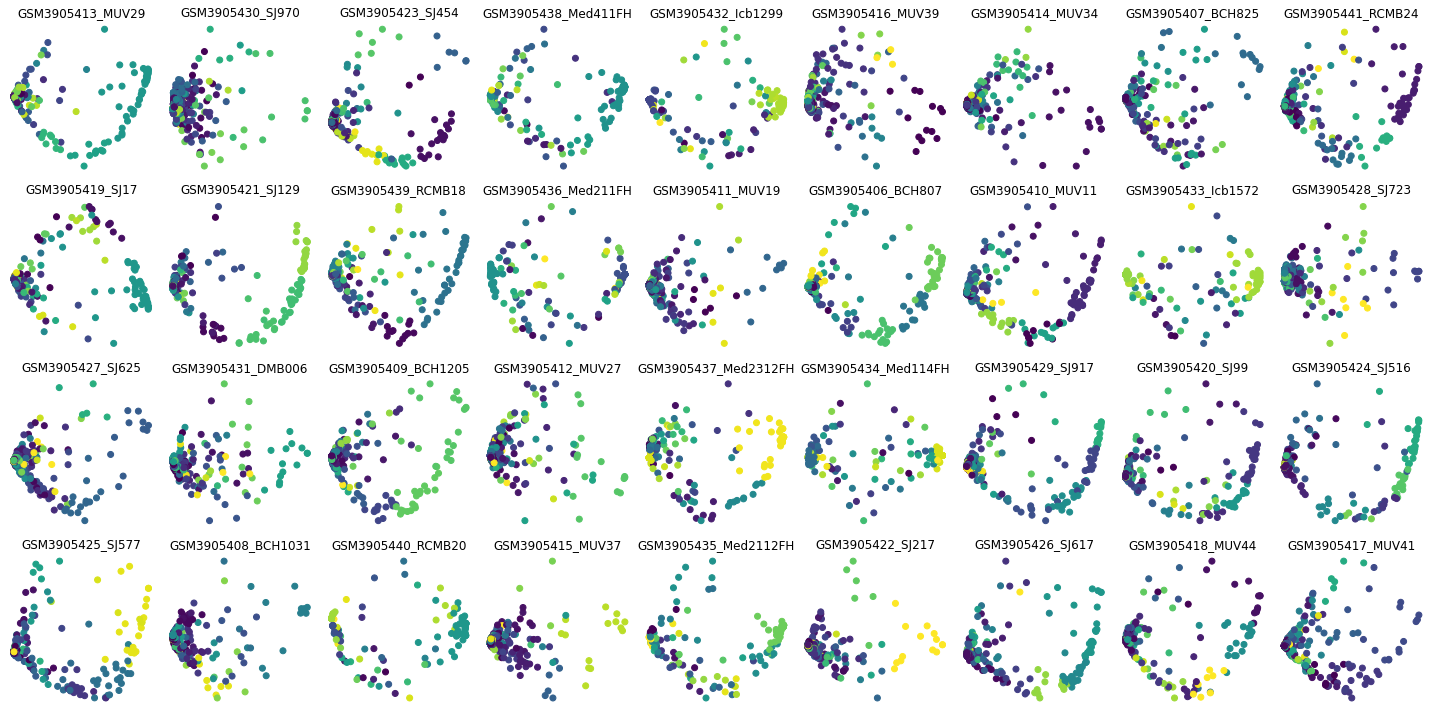

In [5]:
COLS = 9
fig, axes = plt.subplots(nrows=int(len(clustered_patients)/COLS), ncols=COLS, figsize=(20,10))
ax = axes.flatten()

for ix, _ in enumerate(clustered_patients):
    plastic.plot.clusters(patients[ix], clustered_patients[ix], ax=ax[ix])
    ax[ix].set_axis_off()
    ax[ix].set_title(patients_names[ix])
plt.tight_layout()

# Phylogeny inference

In [6]:
inferred_trees = list()
for ix, p in enumerate(clustered_patients):
    try:
        t = pickle.load(open(f'medullo/inferred/{patients_names[ix]}.p', 'rb'))
    except:
        t = plastic.phylogeny.inference(p, alphas=0.25, beta=1e-4, k=0, max_deletions=0, cores=4, get_cells=True)
        pickle.dump(t, open(f'medullo/inferred/{patients_names[ix]}.p', 'wb'))
    inferred_trees.append(t)

### Plot using SASC-viz visualization features

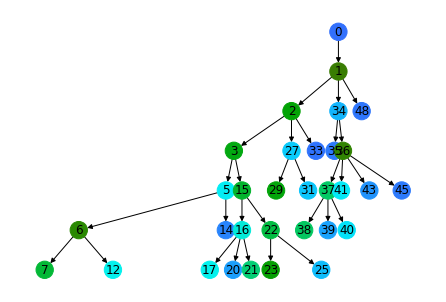

In [7]:
plastic.plot.phylogeny(
    inferred_trees[0]['inferred_tree'].with_visualization_features(support_threshold=0.2, collapse_simple_paths=True), 
    show_support=True, 
    labels=None
)

### Plot with labels

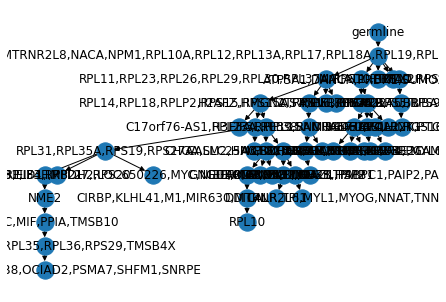

In [8]:
# not particularly good-looking on this example
plastic.plot.phylogeny(
    inferred_trees[0]['inferred_tree'].without_cells(), 
    show_labels=True
)

### Plot all trees

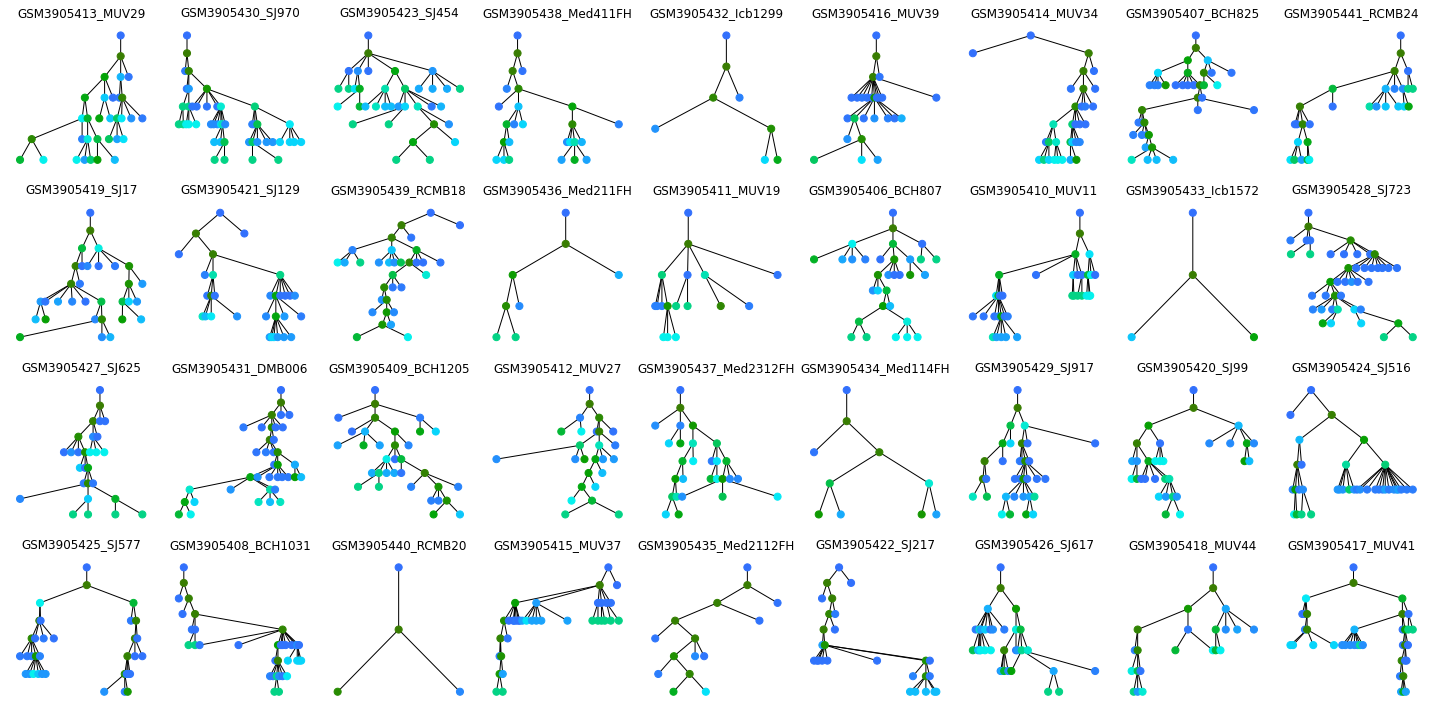

In [9]:
COLS = 9
fig, axes = plt.subplots(nrows=int(len(inferred_trees)/COLS), ncols=COLS, figsize=(20,10))
ax = axes.flatten()

for ix, p in enumerate(inferred_trees):
    plastic.plot.phylogeny(
        p['inferred_tree'].with_visualization_features(support_threshold=0.2, collapse_simple_paths=True), 
        show_support=True,
        # all additional plotting parameters are passed down to nx.draw()
        ax=ax[ix],
        node_size=50,
        arrowstyle='-'
    )
    ax[ix].set_axis_off()
    ax[ix].set_title(patients_names[ix])
    
plt.tight_layout()

# Compare trees

In [10]:
try:
    similarity_matrix = np.loadtxt('medullo/treesim/similarities.csv', delimiter=',')
except:
    similarity_matrix = np.ones((len(inferred_trees), len(inferred_trees)))
    for i in range(similarity_matrix.shape[0]):
        for j in range(i+1, similarity_matrix.shape[1]):
            s = plastic.treesim.similarity(
                inferred_trees[i]['inferred_tree'].without_cells(),
                inferred_trees[j]['inferred_tree'].without_cells(),
                cores=8
            )
            similarity_matrix[i][j] = s
            similarity_matrix[j][i] = s
    np.savetxt('medullo/treesim/similarities.csv', similarity_matrix, delimiter=',')

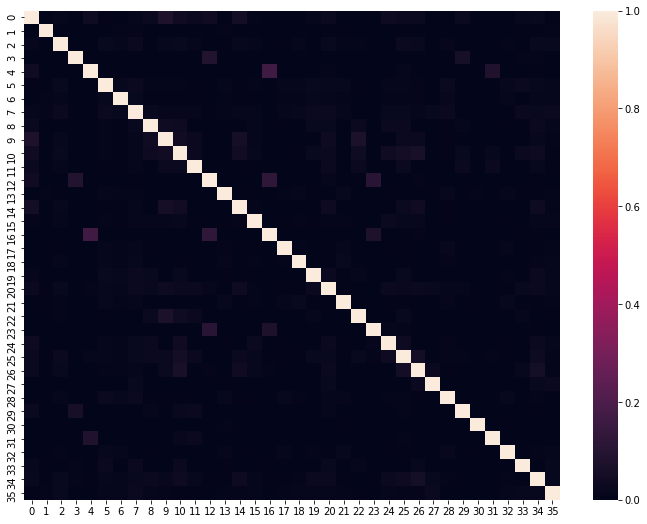

In [11]:
plt.figure(figsize=(12,9))
plastic.plot.similarity_matrix(similarity_matrix)